In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Toy model

Рассмотрим задачу: дано два набора точек $\{ x^{(1)}, y^{(1)} \}$, $\{ x^{(2)}, y^{(2)} \}$.

Значения $\{ y^{(1)} \}$ и $\{ y^{(2)} \}$ имеют случайные погрешности с $\sigma_1$ и $\sigma_2$ соответственно.

Пусть значения $\{ x^{(1)} \}$ имеют общую систематическую погрешность $\Delta x_1$, точки $\{ x^{(2)} \}$ - $\Delta x_2$. Обратите внимание, что это не индивидуальные погрешности для каждой точки с одинаковыми характеристиками, а общий случайный сдвиг всего набора данных (аналогично систематической погрешности определения энергии при восстановлении спектра).

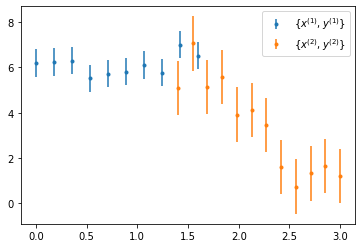

In [2]:
x_1 = np.linspace(0, 1.6, 10)
x_2 = np.linspace(1.4, 3, 12)

y_1 = 6 - 0.3 * x_1 + np.random.normal(loc=0, scale=0.8, size=x_1.size)
y_2 = 10 - 3 * x_2 + np.random.normal(loc=0, scale=1, size=x_2.size)

sigma_1 = 0.6
sigma_2 = 1.2

fig, ax = plt.subplots()

ax.errorbar(x_1, y_1, yerr=sigma_1, fmt='.', label="${ \{ x^{(1)}, y^{(1)} \} }$")
ax.errorbar(x_2, y_2, yerr=sigma_2, fmt='.', label="${ \{ x^{(2)}, y^{(2)} \} }$")

ax.legend()
plt.show()

## Байсовская задача оценки параметров

Поставим задачу следующим образом: найти вероятность того, что все эти точки в сумме описываются законом $y = k - x$ с единственным свободным параметром -- свободным членом $k$.

Для этого найдём best-fit $k$ с помощью метода максимального правдоподобия, интегрируя по $\Delta x_1$ и $\Delta x_2$ как по nuisance-параметрам.

Для общности подхода будем использовать чисто численный метод, не используя линейность теоретической функции. Сначала запишем теорему Байеса, вводя принятые обозначения:

$$
\Theta = (k, \Delta x_1, \Delta x_2)
\\
X = (x^{(1)}, x^{(2)}, y^{(1)}, y^{(2)})
$$

 Также используем тот факт, что для метода Монте-Карло с марковскими цепями (Markov Chain Monte Carlo) не требуется соблюдать нормировку распределения на единицу, поэтому знаменатель в правой части теоремы Байеса можно опустить.

$$
P(\Theta | X) \propto P(X | \Theta) P_{prior}(\Theta)
$$

Введём принятые обозначения $P_{prior}(\Theta) \equiv \pi(\Theta)$, $P(X | \Theta) \equiv \mathcal{L}(\Theta)$. В нашей задаче

$$
\pi(\Theta) = \pi(k, \Delta x_1, \Delta x_2) \propto N(0, \sigma_{\Delta {x_1}}) \; N(0, \sigma_{\Delta {x_2}})
\\
\mathcal{L}(\Theta) = \mathcal{L}(k, \Delta x_1, \Delta x_2) \propto \prod_i \exp \left( - \frac{(y_i^{(1)} - (k - (x_i^{(1)} + \Delta x_1)))^2}{2 \sigma_1^2} \right) \; \prod_j \exp \left( - \frac{(y_j^{(2)} - (k - (x_j^{(2)} + \Delta x_2)))^2}{2 \sigma_2^2} \right)
$$

Здесь предполагается, что значения $y$ распределены нормально с соответствующими $\sigma$.

In [80]:
sigma_delta_x_1 = 3
sigma_delta_x_2 = 2

In [81]:
from numba import njit

@njit
def logprior(theta):
    k, delta_x_1, delta_x_2 = theta
    return - (delta_x_1)**2 / (2 * sigma_delta_x_1**2) - (delta_x_2)**2 / (2 * sigma_delta_x_2**2)

@njit
def loglikelihood(theta):
    k, delta_x_1, delta_x_2 = theta
    logL = 0
    for x, y in zip(x_1, y_1):
        logL -= (y - (k - (x + delta_x_1)))**2 / (2 * sigma_1**2)
    for x, y in zip(x_2, y_2):
        logL -= (y - (k - (x + delta_x_2)))**2 / (2 * sigma_2**2)
    return logL

@njit
def logposterior(theta):
    return logprior(theta) + loglikelihood(theta)


## MCMC-сэмплирование

Задача сэмплера -- получение выборки из распределения, зная только его функцию плотности вероятности (PDF), часто даже без нормировки. В нашем случае в качестве функции плотности вероятности -- апостериорное распределение вектора $\Theta$, логарифм которого вычисляет функция `logposterior`.

Будем использовать MCMC-сэмплер `emcee`, реализующий афинно-инвариантный сэмплинг, что позволяет вектору параметров иметь разные порядки величин по разным измерениям.

In [82]:
import emcee

n_walkers = 64
n_dim = 3
sampler = emcee.EnsembleSampler(n_walkers, n_dim, logposterior)

In [83]:
theta_estimation = np.array([0, 0, 0], dtype='float')
theta_sigmas_for_starting_points = np.array([5, 1, 1], dtype='float')

starting_points = np.tile(theta_estimation, (n_walkers, 1))
for i, sigma in enumerate(theta_sigmas_for_starting_points):
    starting_points[:, i] += np.random.normal(loc=0, scale=sigma, size=(n_walkers,))

In [84]:
sampler.run_mcmc(starting_points, 10000)

print('done')

done


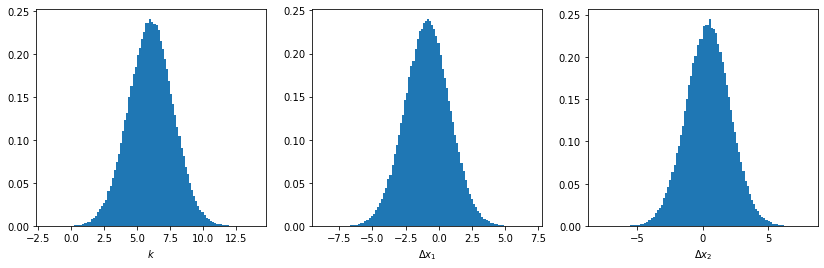

In [103]:
sample = sampler.get_chain(flat=True, thin=1, discard=1000)

k_sample = sample[:, 0]
delta_x_1_sample = sample[:, 1]
delta_x_2_sample = sample[:, 2]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

ax1.set_xlabel('$k$')
ax1.hist(k_sample, bins=100, density=True)

ax2.set_xlabel('$\Delta x_1$')
ax2.hist(delta_x_1_sample, bins=100, density=True)

ax3.set_xlabel('$\Delta x_2$')
ax3.hist(delta_x_2_sample, bins=100, density=True)

plt.show()

In [104]:
k_est = k_sample.mean()
delta_x_1_est = delta_x_1_sample.mean()
delta_x_2_est = delta_x_2_sample.mean()

## Оценка качества наилучшего фита после интегрирования по nuisance-параметрам

In [111]:
from sklearn.metrics import r2_score

In [112]:
y_true = np.concatenate((y_1, y_2))

In [113]:
y_predicted = []
for x in x_1:
    y_predicted.append(k_est - (x + delta_x_1_est))
for x in x_2:
    y_predicted.append(k_est - (x + delta_x_2_est))
y_predicted = np.array(y_predicted)

$R^2$-метрика для оценки качества фита при оптимальных (консервативных, если цель -- отвергнуть гипотезу) значения nuisance-параметров:

In [116]:
print(r2_score(y_true, y_predicted))

0.6172287618101339
